## Processing sensor data from Shale Hills CZO LRMS site ##

- Marc Berghouse 8/8/2020: Original format
- Zach Perzan 9/23/202: Improved format and working PRISM concat

This array includes:
- Apogee Instruments SO-110 O2 sensors
- Eosense EosGP CO2 sensors

Other data includes:
- PRISM daily precipitation




In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

def remove_spikes(df, column, window=7, threshold=1):
    """Given a dataframe and column, remove values that are different 
    from the rolling median. For example, with window=5 and threshold=1000 ppm,
    values that are more than 1000 ppm off from the 5-value rolling median will
    be set to NaN.
    
    params: 
        df [dataframe]: dataframe in which the 
        column [str]: name of the column to modify within df
        window [int]: number of records over which to take the median
        threshold [float]: threshold difference above which values are 
            removed (set to NaN)
            
    returns:
        nothing (modifies data in place)
    """
    
    data = df[column].copy()
    
    rollmed = data.rolling(window).median()
    diff = (data - rollmed).abs()
    mask = diff > threshold
    data[mask] = np.nan
    
    df[column] = data

In [2]:
infiles= ["../../raw_data/Shale Hills/LRMS/LRMS_CO2_O2.csv" ]
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Shale Hills/Precipitation/PRISM_GarnerRun.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=["Record", "DiffVolt_30cm.mV", "DiffVolt_140cm.mV", "O2_30cm.percent.0-100",
          "O2_140cm.percent.0-100",  "ApogeeTemp_30cm.deg.C" , "ApogeeTemp_140cm.deg.C", 
          "CO2lo_30cm.ppm","CO2hi_30cm.ppm", "GPTemp_30cm.deg.C", "CO2lo_140cm.ppm",
          "CO2hi_140cm.ppm", "GPTemp_140cm.deg.C"]



# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2015-06-10', '2017-02-20'), errors='ignore')
ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')


hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

In [4]:
df=df.drop(columns="Record")
df=df.drop(columns="DiffVolt_30cm.mV")
df=df.drop(columns="DiffVolt_140cm.mV")


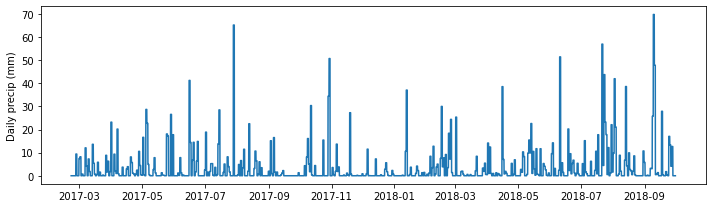

In [5]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

In [6]:
#Only use precip data when there is also good CO2 data

df['PRISM_precip.mm']=df['PRISM_precip.mm'].loc[:'2018-04-18']


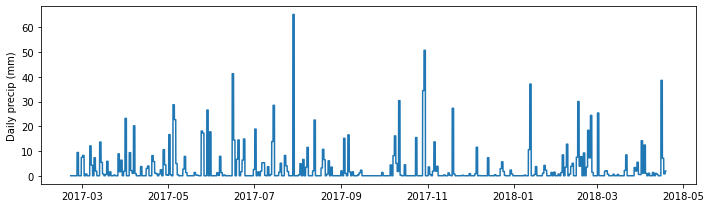

In [7]:
# Plot corrected precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

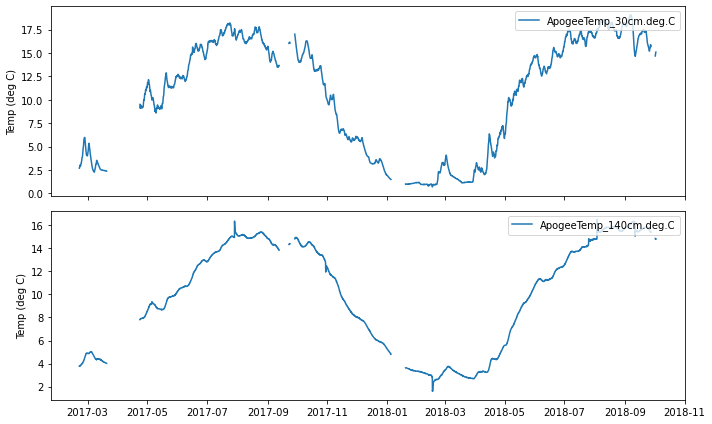

In [8]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

In [9]:
#Only use temperature data when there is also good CO2 data

df['ApogeeTemp_30cm.deg.C']=df['ApogeeTemp_30cm.deg.C'].loc[:'2018-04-18']
df['ApogeeTemp_140cm.deg.C']=df['ApogeeTemp_140cm.deg.C'].loc[:'2018-02-23']

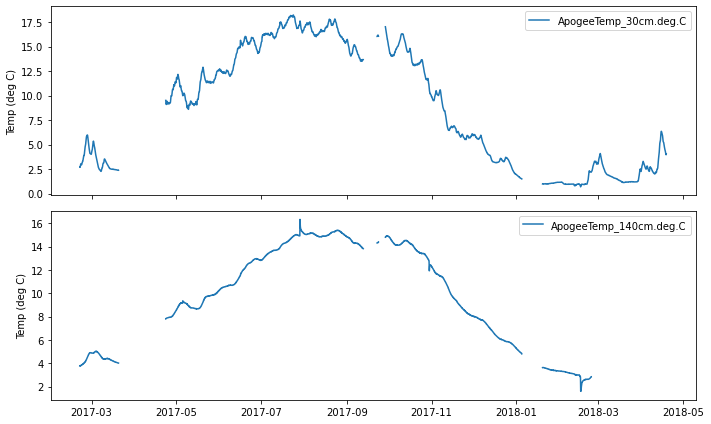

In [10]:
# Plot corrected apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

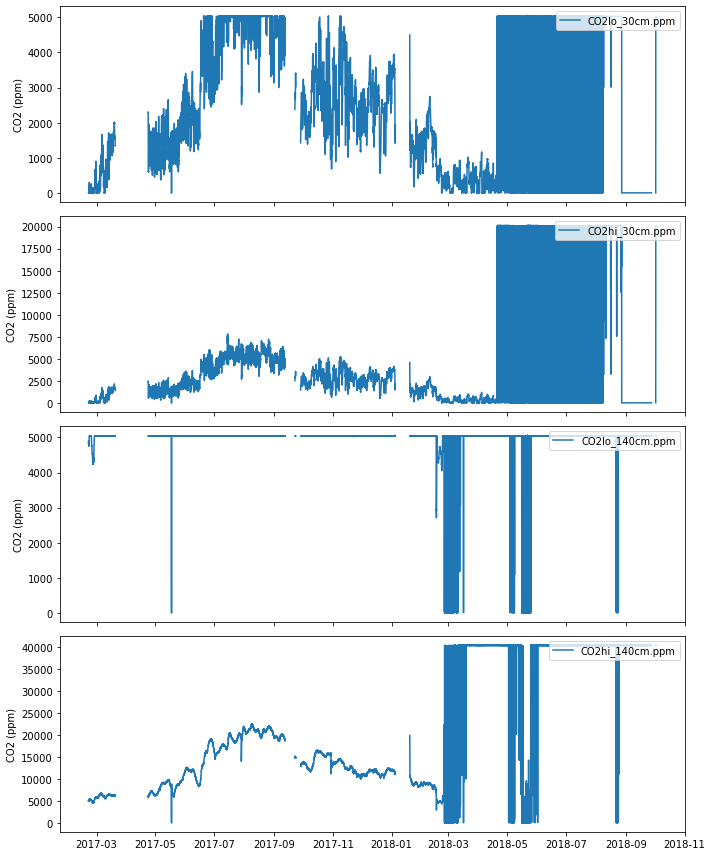

In [11]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [12]:
#Combine lo and hi based on sensor limits
mask = df['CO2lo_30cm.ppm'] < 5000
df.loc[mask, 'CO2_30cm.ppm'] = df.loc[mask, 'CO2lo_30cm.ppm']
df.loc[~mask, 'CO2_30cm.ppm'] = df.loc[~mask, 'CO2hi_30cm.ppm']
mask2 = df['CO2lo_140cm.ppm'] < 5000
df.loc[mask2, 'CO2_140cm.ppm'] = df.loc[mask2, 'CO2lo_140cm.ppm']
df.loc[~mask2, 'CO2_140cm.ppm'] = df.loc[~mask2, 'CO2hi_140cm.ppm']

In [13]:
#Only use good CO2 data
df=df.drop(columns='CO2lo_30cm.ppm')
df=df.drop(columns='CO2lo_140cm.ppm')
df=df.drop(columns='CO2hi_30cm.ppm')
df=df.drop(columns='CO2hi_140cm.ppm')
df['CO2_30cm.ppm']=df['CO2_30cm.ppm'].loc[:'2018-04-18']
df['CO2_140cm.ppm']=df['CO2_140cm.ppm'].loc[:'2018-02-23']



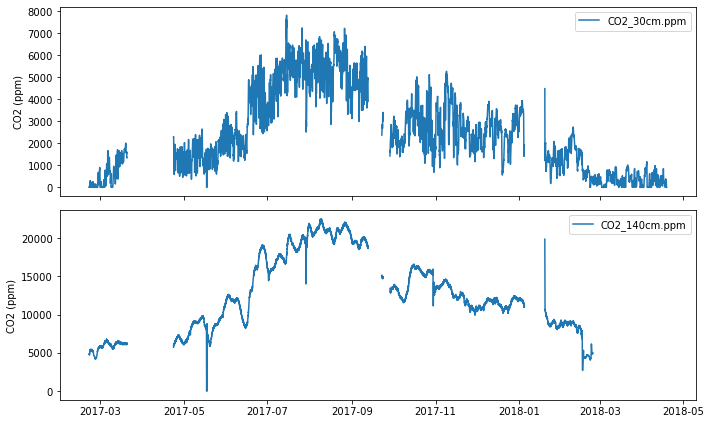

In [14]:
# Plot corrected CO2 data

co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

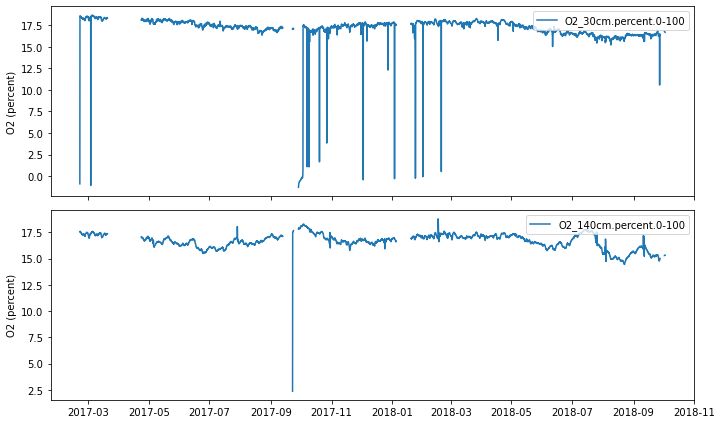

In [15]:
# Plot O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [16]:
#Only use O2 data when there is also good CO2 data
df['O2_30cm.percent.0-100']=df['O2_30cm.percent.0-100'].loc[:'2018-04-18']
df['O2_140cm.percent.0-100']=df['O2_140cm.percent.0-100'].loc[:'2018-02-23']
df.loc[df['O2_30cm.percent.0-100'] < 1, 'O2_30cm.percent.0-100'] = np.nan
df.loc[df['O2_140cm.percent.0-100'] < 3, 'O2_140cm.percent.0-100'] = np.nan
remove_spikes(df, 'O2_140cm.percent.0-100', window=5, threshold=1)
remove_spikes(df, 'O2_30cm.percent.0-100', window=5, threshold=1)



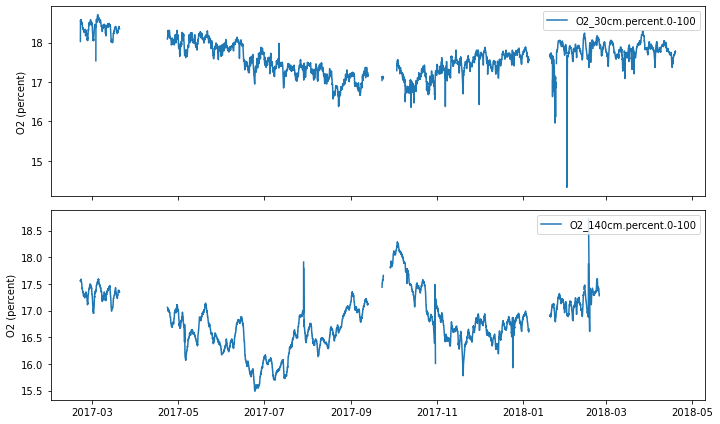

In [17]:
# Plot corrected O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

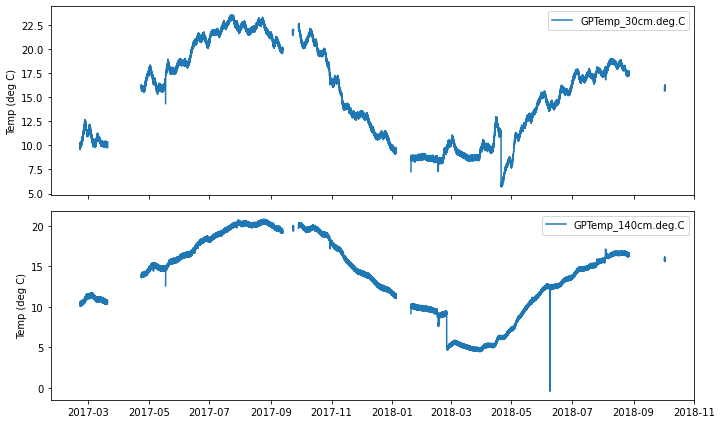

In [18]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'GPTemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [19]:
df=df.drop(columns='GPTemp_30cm.deg.C')
df=df.drop(columns='GPTemp_140cm.deg.C')

In [20]:
output=df.copy()
outfile = '../../processed_data/Shale_Hills/LRMS_CO2_O2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.EST')

In [21]:
output

,O2_30cm.percent.0-100,O2_140cm.percent.0-100,ApogeeTemp_30cm.deg.C,ApogeeTemp_140cm.deg.C,PRISM_precip.mm,CO2_30cm.ppm,CO2_140cm.ppm
TmStamp,,,,,,,
2017-02-20 15:00:00,NaN,17.559999,2.689,3.773,NaN,8.108109,4835.1362
2017-02-20 16:00:00,18.030001,17.570000,2.688,3.771,NaN,2.702703,4846.6221
2017-02-20 17:00:00,18.510000,17.570000,2.705,3.766,NaN,5.405406,4867.5679
2017-02-20 18:00:00,18.570000,17.549999,2.704,3.787,NaN,8.108109,4905.4058
2017-02-20 19:00:00,18.540001,17.549999,2.697,3.780,NaN,3.378379,4866.8931
...,...,...,...,...,...,...,...
2018-10-02 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-02 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
